Misclassification Errors:
  k  Train Error  Test Error
 10     0.273333    0.283333
 30     0.113333    0.160000
100     0.043333    0.106667
300     0.006667    0.076667
500     0.003333    0.080000


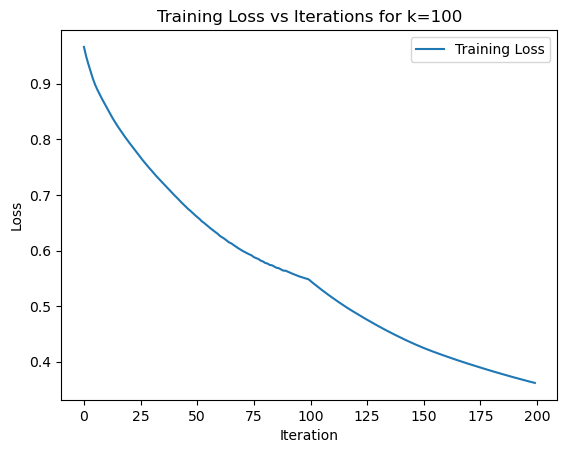

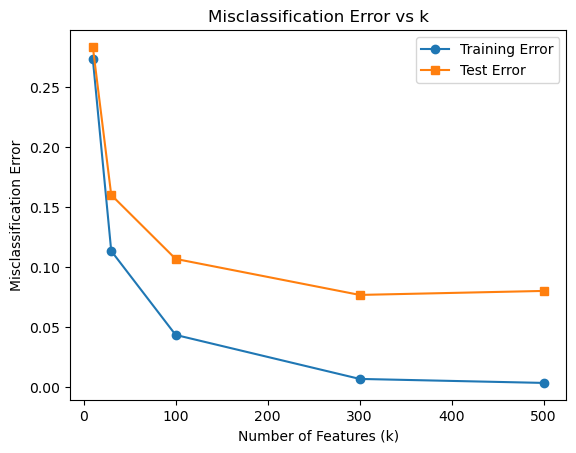

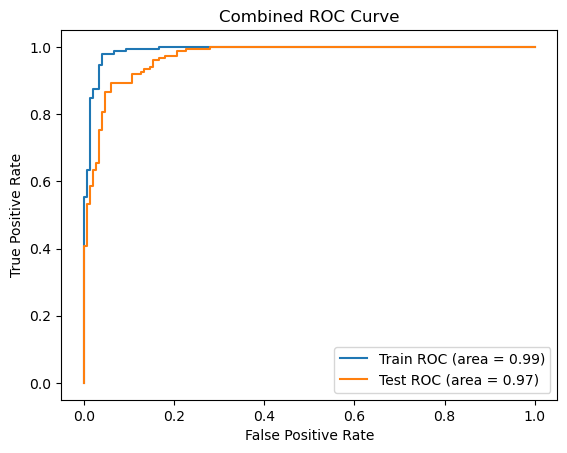

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, roc_curve, auc

X = pd.read_csv(r"C:\Users\basak\Documents\MS-Data Science\Spring-2025\Python\ML HW\dataset\dexter_train.csv", header=None)
y = pd.read_table(r"C:\Users\basak\Documents\MS-Data Science\Spring-2025\Python\ML HW\dataset\dexter_train.labels", header=None).squeeze()
X_test = pd.read_csv(r"C:\Users\basak\Documents\MS-Data Science\Spring-2025\Python\ML HW\dataset\dexter_valid.csv", header=None)
y_test = pd.read_table(r"C:\Users\basak\Documents\MS-Data Science\Spring-2025\Python\ML HW\dataset\dexter_valid.labels", header=None).squeeze() 

y = np.array(y)  
y_test = np.array(y_test) 
X = np.array(X)
X_test = np.array(X_test)

mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
std[std == 0] = 1 
X = (X - mean) / std
X_test = (X_test - mean) / std 

s = 0.001
mu = 200
N_iter = 200
h = 0.1

def huberized_svm(y, y_pred):
    mar = y * y_pred
    loss = np.where(mar > 1 + h, 0, np.where(np.abs(1 - mar) <= h, ((1 + h - mar) ** 2) / (4 * h), 1 - mar))
    return np.mean(loss)

def gradient_update(X, y, beta, s = 0.001):
    y_pred = np.dot(X, beta)
    mar = y * y_pred
    mask = mar < 1 - h
    gradient = np.zeros_like(X)
    gradient[mask] = -y[mask, np.newaxis] * X[mask]
    return beta - s * np.mean(gradient, axis=0)

def inverse_schedule(i, k, p):
    return int(k + (p - k) * max(0, (N_iter - 2 * i) / (2 * i * mu + N_iter)))

def mis_error(y, y_pred):
    return np.mean(np.sign(y_pred) != y)

def FSA_train(X, y, X_test, y_test, k_values=[10, 30, 100, 300, 500]):
    p = X.shape[1]
    results = {}
    errors = []
    
    for k in k_values:
        beta = np.zeros(p)
        loss_history = []
        selected_features = np.arange(p)
        
        for i in range(1, N_iter + 1):
            beta = gradient_update(X[:, selected_features], y, beta)
            M_i = inverse_schedule(i, k, p)
            top_features = np.argsort(np.abs(beta)**2)[-M_i:]
            selected_features = selected_features[top_features]
            beta = beta[top_features]
            loss_history.append(huberized_svm(y, np.dot(X[:, selected_features], beta)))
        
        y_pred = np.dot(X[:, selected_features], beta)
        y_test_pred = np.dot(X_test[:, selected_features], beta)
        train_error = mis_error(y, y_pred)
        test_error = mis_error(y_test, y_test_pred)
        
        errors.append([k, train_error, test_error])
        
        results[k] = {
            "beta": beta,
            "features": selected_features,
            "loss_history": loss_history,
            "train_error": train_error,
            "test_error": test_error
        }
    
    return results, errors

results, errors = FSA_train(X, y, X_test, y_test)

df_errors = pd.DataFrame(errors, columns=['k', 'Train Error', 'Test Error'])
print("Misclassification Errors:")
print(df_errors.to_string(index=False))


plt.plot(range(len(results[100]["loss_history"])), results[100]["loss_history"], label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss vs Iterations for k=100')
plt.legend()
plt.show()

errors = np.array(errors)
plt.plot(errors[:, 0], errors[:, 1], marker='o', label='Training Error')
plt.plot(errors[:, 0], errors[:, 2], marker='s', label='Test Error')
plt.xlabel('Number of Features (k)')
plt.ylabel('Misclassification Error')
plt.title('Misclassification Error vs k')
plt.legend()
plt.show()


fpr_train, tpr_train, _ = roc_curve(y, np.dot(X[:, results[100]["features"]], results[100]["beta"]))
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y_test, np.dot(X_test[:, results[100]["features"]], results[100]["beta"]))
roc_auc_test = auc(fpr_test, tpr_test)
plt.plot(fpr_train, tpr_train, label=f'Train ROC (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (area = {roc_auc_test:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curve')
plt.legend()
plt.show()
